<b>Image Processing Assignment: Transformation</b><br>
C18395266<br>
Timur Sultanov<br>

<b>Description:</b><br>
This program's goal is to restore faded and damaged images supplied by the user.
I couldn't find an algorithm to suit both images for the simple fact that both images have completely different defects. The faded image has a clear border depicting the transition between the faded and non faded region whereas the damaged image does not.<br>

<b>Algorithm for the faded image:</b><br>
In order to fix the faded image, the following operations are performed:<br>

<b>1.</b> Image is read in and converted to grayscale.<br>
<b>2.</b> Edges are located in the image.<br>
<b>3.</b> A blank canvas is created, contours are then found and drawn onto it with the help of the edged image.<br>
<b>4.</b> Intersecting points are located on the contour canvas.<br>
<b>5.</b> Program loops over the intersecting points and discovers the outer most points to ensure entire ROI is captured.<br>
<b>6.</b> The faded region is cropped via the newly found coordinates.<br>
<b>7.</b> The faded region's color is adjusted to match the non faded background.<br>
<b>8.</b> Newly restored cropped region is inserted back into the original image and inpainted to remove marks of an edit.<br>
<b>9.</b> Image is written and displayed.<br>

<b>Algorithm for the damaged image:</b><br>

<b>1.</b> Image is read in.<br>
<b>2.</b> Arguments are created to remove the noise but retain as much information as possible.<br>
<b>3.</b> Image is converted to grayscale.<br>
<b>4.</b> Image is written and displayed.<br>


<b>Research:</b><br>
The first problem which I had was identifying edges so that I could crop the faded region from the image. I looked into various ways of achieving this and one that proved successful was the canny edge detector. "It takes as input a gray scale image, and produces as output an image showing the positions of tracked intensity discontinuities."[1] Once I read how it works I was able to apply it to my program.<br>

Working with the damaged image was a bit tricky since I wasn't sure what I could have actually done to produce meaningful results. After exploring various functions and experimenting with them, I came across a function that removed noise from an image. I googled 'opencv denoisation' and looked at google images to see if I could find something remotely similar to my image. After seeing a sample image 'geeksforgeeks' had done, the image restoration seemed somewhat like my image. I read their article "Python | Denoising of colored images using opencv"[2] after which I tried to apply the same function on my image and the result it outputted looked like an improved version of the original image.

Another problem which I encountered was determining how I would come up with an algorithm to determine which restoration function to run the image against. First I looked into converting both images into grayscale and then displaying regular histograms to determine the difference but both images had a mixture of dark and light pixels. I looked into analysing the RGB color channels and mapping them to a histogram to see what color channels were prevalent in each image so that I could find something different between the 2 images. I read about "Multi-dimensional Histograms"[3] where I learned it's possible to map each color channel onto the same histogram so that they would overlap and I could compare them.<br>

This is the approach I used and found that for the damaged image, the pixel intensity distribution was more towards the lighter side (closer to 255) for the brightest color channels and for the faded image, it was generally under 100.

<b>References:</b><br>
1. Canny Edge Detector [Internet]. homepages.inf.ed.ac.uk 2003 [cited 2021 Oct 31].
   Available from: https://homepages.inf.ed.ac.uk/rbf/HIPR2/canny.htm<br>
2. Python | Denoising of colored images using opencv [Internet]. geeksforgeeks.org 2019 [cited 2021 Oct 31].
   Available from: https://www.geeksforgeeks.org/python-denoising-of-colored-images-using-opencv/<br>
3. Clever Girl: A Guide to Utilizing Color Histograms for Computer Vision and Image Search Engines [Internet].
   pyimagesearch.com 2014 [cited 2021 Oct 31].
   Available from: https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/

In [1]:
import cv2
import easygui
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_in_image():
    """
    Function to read in a user selected image
    :return: returns the damaged image selected by the user
    """
    easygui.msgbox("Welcome to Timur's photo restoration. Please select a damaged image you would like to restore.",
                   title="Photo Restoration App",
                   ok_button="Select Image")

    return cv2.imread(easygui.fileopenbox())

In [3]:
def process_faded(img):
    """
    Function that holds nested functions used to restore the faded image
    :param img: original faded image that requires restoration
    :return: fixed and restored image
    """
    def find_edges():
        """
        Function that locates edges in the image, this will be used
        so that we can locate the ROI (faded region)
        :return: copy of the grayscale image with detected edges
        """
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Highlight the edges in the image
        lower_threshold = 70
        edge_gray = cv2.Canny(gray, lower_threshold, 200)

        # Creating a copy of the gray image
        return edge_gray.copy()

    def find_and_draw_contours(edge):
        """
        Function that detects and draws contours on the image with detected edges
        :param edge: grayscale image with highlighted edges
        :return: canvas with contours drawn on
        """
        h, w, d = img.shape

        # Find contours in the gray image
        contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Creating a blank canvas same size of the original image where I'll draw contours
        blank_for_contours = np.zeros((h, w, d), np.uint8)

        # Drawing the contours in red color on the blank canvas
        cv2.drawContours(blank_for_contours, contours, -1, (0, 0, 255), 2)

        return blank_for_contours

    def find_intersecting_points_of_contours(blank_contours):
        """
        Function that locates the intersecting points of contours
        :param blank_contours: canvas with drawn on contours
        :return: canvas with detected contours in the intersection
        """
        # Lines which represent the thickness of the edge of the damaged area
        horizontal_damaged_line = (60, 1)
        vertical_damaged_line = (1, 60)

        # Creating a rectangular kernel
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, horizontal_damaged_line)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, vertical_damaged_line)

        # Applying horizontal and vertical kernels to find horizontal/vertical straight edges
        detect_horizontal = cv2.morphologyEx(blank_contours, cv2.MORPH_OPEN, horizontal_kernel)
        detect_vertical = cv2.morphologyEx(blank_contours, cv2.MORPH_OPEN, vertical_kernel)

        # Applying bitwise and operator to find the intersection of the vertical and horizontal edges
        intersection = cv2.bitwise_and(detect_horizontal, detect_vertical)
        intersection = cv2.cvtColor(intersection, cv2.COLOR_BGR2GRAY)

        # Detecting contours in the intersection
        contours = cv2.findContours(intersection, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

        return contours

    def find_coordinates_of_faded_region(contours):
        """
        Function that locates the coordinates of the ROI (faded area)
        :param contours: contours found in the image
        :return: coordinates of the ROI
        """
        # Getting the image shape
        h, w, d = img.shape

        # Looping through the contours to detect insecting points which will be our faded region
        intersection_coordinates = []
        for item in contours:
            horizontal = item[0][0][0]
            vertical = item[0][0][1]

            intersection_coordinates.append((horizontal, vertical))

        # Coordinate points which represent the location of the faded region
        x1y1 = (w, h)
        x2y2 = (0, 0)

        # Looping over the intersection coordinates (4 corners of a rectangle)
        for point in intersection_coordinates:
            horizontal, vertical = point[0], point[1]

            # Finding the most top left outer and bottom right outer coordinates
            if horizontal + vertical < x1y1[0] + x1y1[1]: x1y1 = (horizontal, vertical)
            if horizontal + vertical > x2y2[0] + x2y2[1]: x2y2 = (horizontal, vertical)

        return x1y1, x2y2

    def cropping_faded_region(top_left, bottom_right):
        """
        Function that crops the faded region given 2 coordinates, top left and bottom right of the boundary
        :param top_left: x1,y1 coordinates of the ROI
        :param bottom_right: x2,.y2 coordinates of the ROI
        :return: blank canvas the size and depth of the original colored image
        :return: cropped image at the faded region
        """
        # Getting a copy of the original image
        img_crop = img.copy()

        # Cropping original image at the coordinates that denote the faded region
        img_crop = img_crop[top_left[1]: bottom_right[1], top_left[0]: bottom_right[0]]

        # Getting the dimensions of the cropped image
        cropped_h, cropped_w, cropped_d = img_crop.shape

        # Creating a blank canvas the size of the cropped image
        return np.zeros((cropped_h, cropped_w, 3), np.uint8), img_crop

    def fixing_color_of_faded_region(blank_canvas, img_crop):
        """
        Function that fixes the faded region by modifying the color value
        :param blank_canvas: empty canvas the size of the original image
        :param img_crop: cropped image
        :return: image after subtracting the modified canvas
        """
        # Creating a blank canvas and adding 30 pixels to it
        blank_canvas = blank_canvas + 30

        # Subtracting the black modified canvas from the cropped image
        return cv2.subtract(img_crop, blank_canvas)

    def restoring_faded_region_with_new(darkened_img, top_left, bottom_right):
        """
        Function that restores the faded region in the image
        :param darkened_img: original image that has been darkened:
        :param top_left: x1,y1 coordinate of the faded region:
        :param bottom_right: x2, y2 coordinate of the faded region:
        :return: Returns the image that was inpainted by a mask
        """
        h, w, d = img.shape

        # Creating a copy of original image
        restored_img = img.copy()

        # Inserting the darkened image into the original image at the coordinates where the faded region is
        restored_img[top_left[1]: bottom_right[1], top_left[0]:bottom_right[0]] = darkened_img

        # creating a mask same size of the original image
        border_blend_mask = np.zeros((h, w, 3), np.uint8)

        # Drawing a rectangle on the empty black canvas in white which will be used to inpaint the image
        cv2.rectangle(border_blend_mask, top_left, bottom_right, (255, 255, 255), 4)

        # Converting the mask to grayscale
        border_mask = cv2.cvtColor(border_blend_mask, cv2.COLOR_BGR2GRAY)

        return cv2.inpaint(restored_img, border_mask, 3, cv2.INPAINT_TELEA)

    # Find edges in the image
    edges = find_edges()

    # Draw contours on the image with edges
    canvas = find_and_draw_contours(edges)

    # Find the intersection points of the contours
    contour_region = find_intersecting_points_of_contours(canvas)

    # Find the coordinates of the faded rectangle
    point_a, point_b = find_coordinates_of_faded_region(contour_region)

    # Crop the faded region from the original image so that we can work on it
    black_mask, cropped_region = cropping_faded_region(point_a, point_b)

    # Fix the color of the faded region
    modified_img = fixing_color_of_faded_region(black_mask, cropped_region)

    # Add the restored cropped image back into the original and blend edges
    restored_img = restoring_faded_region_with_new(modified_img, point_a, point_b)

    return restored_img

In [4]:
def process_damaged(img):
    """
    Function that restores the damage in an image
    :param img: image that is being processed
    :return: denoised image
    """

    # Arguments for the function to remove noise from the image
    filter_strength = 8
    color_components = 10
    template_window_size = 7
    search_window_size = 21

    # Denoise the image
    denoised = cv2.fastNlMeansDenoisingColored(img, None, filter_strength, color_components, template_window_size, search_window_size)

    return cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

In [5]:
def find_highest_peaks_of_colors(img):
    """
    Function to find the highest x value of a color channel (brightness of it, 255 being the brightest),
    this way we know which algorithm to select for the image
    :param img: original image that is being worked on
    :return: highest value of a color channel
    """

    color_values = []
    colors = []

    # Create a histogram of each seperate color channel
    # This will allow us to see which color channels are prevalent in the image we're restoring
    [color_values.append(cv2.calcHist([img], [j], None, [256], [0, 256])) for j in range(0, 3)]

    # Appending each ravelled histogram to an array
    colors.append(color_values[0].ravel())
    colors.append(color_values[1].ravel())
    colors.append(color_values[2].ravel())

    indices = list(range(0, 256))

    set_arr = []
    for i in range(0, 3):
        zipped = (zip(colors[i], indices))
        sorted_set = sorted(zipped, reverse=True)
        set_arr.append(sorted_set)

    # Get the BGR values separately
    b = [(i, j) for j, i in set_arr[0]]
    g = [(i, j) for j, i in set_arr[1]]
    r = [(i, j) for j, i in set_arr[2]]

    # Index denoting the highest peak in the histogram
    b_index = b[0][0]
    g_index = g[0][0]
    r_index = r[0][0]

    # BGR highest color values in an image (we want to find the brightest index)
    color_peaks = [b_index, g_index, r_index]
    color_peaks.sort()

    # Variable to store the brightest color channel (255 being the highest)
    highest_val = 0

    # Loop through the color peaks and find the highest value out of the color channels
    for i in range(0, len(color_peaks)):
        if color_peaks[i] > highest_val:
            highest_val = color_peaks[i]
    return highest_val

In [6]:
def display_img(img, color):
    """
    Function to display the newly restored image
    """
    cv2.imwrite('restoredImage.jpg', img)
    
    # Check to see if we're displaying a colored image or not
    if(color):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(img)
    else:
        plt.imshow(img, cmap="gray")
        
    plt.show()

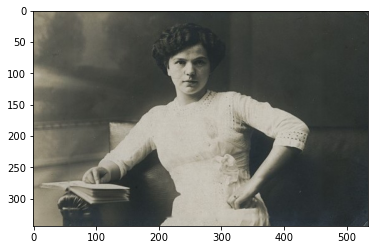

In [7]:
img = read_in_image()
highest = find_highest_peaks_of_colors(img)

# Threshold we're using to distinguish dark images from light images (to see which algorithm is required to run)
brightness_threshold = 100

# Check if majority of the image is dark (I'm using a threshold of 100 to check if an image is dark)
# Display the appropriate image
if highest > brightness_threshold:
    display_img(process_damaged(img), False)
else:
    display_img(process_faded(img), True)